<a href="https://colab.research.google.com/github/Van-Wu1/cycle/blob/main/scr/py/DescriptiveAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!ls '/content/drive/MyDrive/CASA0004_Cycling/data'

Mounted at /content/drive
BoroughShp  CQI  GreatLondonShp  s1  s2_Env  s3


In [2]:
! pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 97.8 MB/s eta 0:00:00


In [3]:
import os
import math
import warnings
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, LineString, MultiLineString
from shapely.ops import linemerge
import rasterio
from rasterio.transform import from_origin
from rasterio.enums import Resampling
from scipy.ndimage import gaussian_filter

## 核密度KDE用不了，能用能用

In [ ]:
'''
# -*- coding: utf-8 -*-
"""
CQI 核密度图（KDE）生成脚本
- 输入: CQI.gpkg (layer = "merged_all_fields"), 需要字段 `cqi_index`
- CRS: EPSG:27700（单位米）
- 输出:
    ./out/cqi_kde_all.tif      # 全道路 KDE（加权）
    ./out/cqi_kde_top20.tif    # 仅前20%高分道路 KDE（加权）
    （可选）对应 PNG 预览
"""

# ---------------- 参数区（按需改动） ----------------
IN_GPKG = "/content/drive/MyDrive/CASA0004_Cycling/data/CQI/CQI.gpkg"
LAYER = "merged_all_fields"

OUT_DIR = "/content/drive/MyDrive/CASA0004_Cycling/data/CQI/fordissertation"
os.makedirs(OUT_DIR, exist_ok=True)

# 线采样间距（米）：越小点越密，越细腻但更耗时/内存
SAMPLE_STEP_M = 10

# KDE 网格分辨率（米）：越小越细腻，文件更大
GRID_RES_M = 10

# 高斯核带宽（米）：控制“扩散/平滑”范围，≈ KDE 带宽
# 经验：400 ~ 800m 比较适合伦敦全域概览
BANDWIDTH_M = 200

# 边界外扩（米）：避免边缘截断
BBOX_BUFFER_M = 500

# 是否导出 PNG 预览（简单渲染，论文请用 GIS 配色）
EXPORT_PNG_PREVIEW = False

# 仅对前多少分位的高分道路做 KDE（例如 0.8 = 前20%）
TOP_Q = 0.8
# ---------------------------------------------------


def safe_read_gpkg(path, layer):
    """优先用 GeoPandas 读取；若环境兼容性问题，则降级为 Fiona→GeoDataFrame。"""
    try:
        gdf = gpd.read_file(path, layer=layer)
        return gdf
    except Exception as e:
        warnings.warn(f"GeoPandas 直接读取失败，尝试降级：{e}")
        import fiona
        from shapely.geometry import shape
        recs = []
        with fiona.open(path, layer=layer) as src:
            crs = src.crs_wkt or src.crs
            for feat in src:
                geom = shape(feat["geometry"]) if feat["geometry"] else None
                props = feat["properties"] or {}
                recs.append({**props, "geometry": geom})
        gdf = gpd.GeoDataFrame(recs, crs=crs)
        return gdf


def sample_points_on_geom(geom, step):
    """对 LineString/MultiLineString 按固定步长采样点（含终点）。"""
    pts = []
    def _sample_line(line: LineString):
        if line.length == 0:
            return
        n = max(1, int(math.floor(line.length / step)))
        dists = [i * step for i in range(n)] + [line.length]
        for d in dists:
            try:
                pts.append(line.interpolate(d))
            except Exception:
                pass

    if isinstance(geom, LineString):
        _sample_line(geom)
    elif isinstance(geom, MultiLineString):
        for part in geom.geoms:
            _sample_line(part)
    else:
        # 尝试合并可能的几何
        try:
            merged = linemerge(geom)
            if isinstance(merged, (LineString, MultiLineString)):
                return sample_points_on_geom(merged, step)
        except Exception:
            pass
    return pts


def build_point_cloud(gdf, value_col="cqi_index", step=SAMPLE_STEP_M):
    """将线要素转为点云（加权），返回 (xs, ys, weights) numpy 数组。"""
    xs, ys, ws = [], [], []
    for geom, val in zip(gdf.geometry.values, gdf[value_col].values):
        if geom is None or np.isnan(val):
            continue
        if val <= 0:
            # 负权或零权对 KDE 没有贡献
            continue

        # 线采样点
        pts = sample_points_on_geom(geom, step)
        if not pts:
            continue

        # 可选权重标准化（这里用线性压缩到[0,1]，避免极端值主导）
        # 也可改为 z-score / 分位裁剪 / winsorize
        w = float(val)
        # 简单保护：过大值截断
        if not np.isfinite(w):
            continue
        xs.extend([p.x for p in pts])
        ys.extend([p.y for p in pts])
        ws.extend([w] * len(pts))

    xs = np.asarray(xs, dtype="float64")
    ys = np.asarray(ys, dtype="float64")
    ws = np.asarray(ws, dtype="float64")

    if len(ws) == 0:
        raise RuntimeError("没有采样到点（检查几何或过滤条件与参数设置）。")

    # 将权重做分位裁剪 + MinMax 到 [0,1]，提升稳健性
    lo, hi = np.quantile(ws, [0.01, 0.99])
    ws = np.clip(ws, lo, hi)
    ws = (ws - ws.min()) / (ws.max() - ws.min() + 1e-9)

    return xs, ys, ws


def raster_kde(xs, ys, ws, bounds, res, bandwidth_m):
    """把加权点云落到网格，再做高斯平滑（KDE）。返回 (arr, transform, bounds)。"""
    minx, miny, maxx, maxy = bounds
    width = int(math.ceil((maxx - minx) / res))
    height = int(math.ceil((maxy - miny) / res))

    # 计算每个点所在网格索引（以行列计）
    col = np.floor((xs - minx) / res).astype(int)
    row = np.floor((maxy - ys) / res).astype(int)

    # 过滤出界点
    mask = (col >= 0) & (col < width) & (row >= 0) & (row < height)
    col = col[mask]; row = row[mask]; ws = ws[mask]

    # 累计权重到像元
    arr = np.zeros((height, width), dtype="float32")
    # 将二维索引转一维，快速累计
    flat_idx = row * width + col
    np.add.at(arr.ravel(), flat_idx, ws)

    # 高斯平滑：sigma(像素) = 带宽 / 分辨率
    sigma = bandwidth_m / res
    if sigma > 0:
        arr = gaussian_filter(arr, sigma=sigma)

    # 生成仿射变换（左上角原点）
    transform = from_origin(minx, maxy, res, res)
    return arr, transform


def save_geotiff(path, arr, transform, crs="EPSG:27700", nodata=0.0):
    meta = {
        "driver": "GTiff",
        "height": arr.shape[0],
        "width": arr.shape[1],
        "count": 1,
        "dtype": "float32",
        "crs": crs,
        "transform": transform,
        "compress": "lzw",
        "tiled": True,
        "nodata": nodata
    }
    with rasterio.open(path, "w", **meta) as dst:
        dst.write(arr.astype("float32"), 1)


def quick_png(path_png, arr):
    """非常简易的 PNG 预览（灰度拉伸）；论文正式配色建议在 GIS 里完成。"""
    import matplotlib.pyplot as plt
    vmin, vmax = np.percentile(arr[arr > 0], [2, 98]) if np.any(arr > 0) else (0, 1)
    plt.figure(figsize=(8, 8))
    plt.imshow(arr, vmin=vmin, vmax=vmax)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(path_png, dpi=300, bbox_inches="tight", pad_inches=0)
    plt.close()


def main():
    # 1) 读数据
    gdf = safe_read_gpkg(IN_GPKG, LAYER)

    # 2) 仅保留有效几何 & 有效 CQI
    assert "cqi_index" in gdf.columns, "缺少字段 cqi_index"
    gdf = gdf[~gdf.geometry.isna()].copy()
    gdf = gdf[np.isfinite(gdf["cqi_index"].values)]
    # CRS 统一为 EPSG:27700
    if (gdf.crs is None) or (str(gdf.crs).upper() not in ["EPSG:27700", "EPSG:27700.0"]):
        gdf = gdf.to_crs(27700)

    # 3) 计算外包框并外扩
    minx, miny, maxx, maxy = gdf.total_bounds
    minx -= BBOX_BUFFER_M; miny -= BBOX_BUFFER_M
    maxx += BBOX_BUFFER_M; maxy += BBOX_BUFFER_M
    bounds = (minx, miny, maxx, maxy)

    # 4) 全体 KDE
    xs, ys, ws = build_point_cloud(gdf, value_col="cqi_index", step=SAMPLE_STEP_M)
    arr_all, transform = raster_kde(xs, ys, ws, bounds, GRID_RES_M, BANDWIDTH_M)
    out_tif_all = os.path.join(OUT_DIR, "cqi_kde_all.tif")
    save_geotiff(out_tif_all, arr_all, transform)
    if EXPORT_PNG_PREVIEW:
        quick_png(os.path.join(OUT_DIR, "cqi_kde_all.png"), arr_all)
    print(f"[OK] 写出全体 KDE → {out_tif_all}")

    # 5) 仅前20%高分 KDE
    thr = np.quantile(gdf["cqi_index"].values, TOP_Q)
    gdf_top = gdf[gdf["cqi_index"] >= thr].copy()
    xs2, ys2, ws2 = build_point_cloud(gdf_top, value_col="cqi_index", step=SAMPLE_STEP_M)
    arr_top, _ = raster_kde(xs2, ys2, ws2, bounds, GRID_RES_M, BANDWIDTH_M)
    out_tif_top = os.path.join(OUT_DIR, "cqi_kde_top20.tif")
    save_geotiff(out_tif_top, arr_top, transform)
    if EXPORT_PNG_PREVIEW:
        quick_png(os.path.join(OUT_DIR, "cqi_kde_top20.png"), arr_top)
    print(f"[OK] 写出前20% KDE → {out_tif_top}")

    print("✓ 全部完成。建议将 GeoTIFF 放进 QGIS/ArcGIS 做正式配色与版式。")


if __name__ == "__main__":
    main()
'''

'\n# -*- coding: utf-8 -*-\n"""\nCQI 核密度图（KDE）生成脚本\n- 输入: CQI.gpkg (layer = "merged_all_fields"), 需要字段 `cqi_index`\n- CRS: EPSG:27700（单位米）\n- 输出:\n    ./out/cqi_kde_all.tif      # 全道路 KDE（加权）\n    ./out/cqi_kde_top20.tif    # 仅前20%高分道路 KDE（加权）\n    （可选）对应 PNG 预览\n"""\n\n# ---------------- 参数区（按需改动） ----------------\nIN_GPKG = "/content/drive/MyDrive/CASA0004_Cycling/data/CQI/CQI.gpkg"\nLAYER = "merged_all_fields"\n\nOUT_DIR = "/content/drive/MyDrive/CASA0004_Cycling/data/CQI/fordissertation"\nos.makedirs(OUT_DIR, exist_ok=True)\n\n# 线采样间距（米）：越小点越密，越细腻但更耗时/内存\nSAMPLE_STEP_M = 10\n\n# KDE 网格分辨率（米）：越小越细腻，文件更大\nGRID_RES_M = 10\n\n# 高斯核带宽（米）：控制“扩散/平滑”范围，≈ KDE 带宽\n# 经验：400 ~ 800m 比较适合伦敦全域概览\nBANDWIDTH_M = 200\n\n# 边界外扩（米）：避免边缘截断\nBBOX_BUFFER_M = 500\n\n# 是否导出 PNG 预览（简单渲染，论文请用 GIS 配色）\nEXPORT_PNG_PREVIEW = False\n\n# 仅对前多少分位的高分道路做 KDE（例如 0.8 = 前20%）\nTOP_Q = 0.8\n# ---------------------------------------------------\n\n\ndef safe_read_gpkg(path, layer):\n    """优先用 GeoPandas 读取；若环境兼容性问题，则降级为 

## 聚合网络，不如arcgis pro自带的，还可以调整网格

In [ ]:
# ! pip install fiona

In [ ]:
'''
# -*- coding: utf-8 -*-
"""
London CQI —— 总览图替代方案（避免 KDE 淹没低值）
输出：
  1) 200m 六边形与方格聚合：cqi_mean / median / min / p10 / p90 / seg_count
  2) Bottom-20% 低值走廊掩膜（用于半透明叠加）
注意：
  - 输入 GPKG: CQI.gpkg, layer="merged_all_fields"
  - CRS: EPSG:27700（单位米）
"""

import os
import math
import warnings
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
from shapely.geometry import Point, Polygon, box
from shapely.ops import unary_union
import fiona

# ========= 参数 =========
IN_GPKG = "/content/drive/MyDrive/CASA0004_Cycling/data/CQI/CQI.gpkg"
LAYER = "merged_all_fields"

OUT_GPKG = "/content/drive/MyDrive/CASA0004_Cycling/data/CQI/fordissertation/CQI_1.gpkg"

# 聚合网格：六边形边到中心距离（≈半径） 与 方格尺寸（米）
HEX_RADIUS_M = 115     # 约等效覆盖面积 ~200m 分辨率（可调 100-250）
SQUARE_SIZE_M = 200

# 低值走廊阈值：后 20%
BOTTOM_Q = 0.2

# 低值走廊缓冲（米）：让线段在地图上更可见
LOW_CORRIDOR_BUFFER = 6

# =======================

def read_as_gdf(path, layer):
    """稳健读取：优先 GeoPandas，失败则 Fiona 手工构建"""
    try:
        gdf = gpd.read_file(path, layer=layer)
        return gdf
    except Exception as e:
        warnings.warn(f"GeoPandas 读取失败，降级 Fiona：{e}")
        recs = []
        with fiona.open(path, layer=layer) as src:
            crs = src.crs_wkt or src.crs
            for feat in src:
                geom = shapely.geometry.shape(feat["geometry"]) if feat["geometry"] else None
                props = feat["properties"] or {}
                recs.append({**props, "geometry": geom})
        gdf = gpd.GeoDataFrame(recs, crs=crs)
        return gdf

def ensure_crs_27700(gdf):
    if gdf.crs is None or "27700" not in str(gdf.crs):
        gdf = gdf.to_crs(27700)
    return gdf

def hex_grid(bounds, radius):
    """生成覆盖 bounds 的六边形网格（点到边中心的半径）"""
    minx, miny, maxx, maxy = bounds
    dx = radius * 2
    dy = math.sqrt(3) * radius

    cols = int(math.ceil((maxx - minx) / dx)) + 2
    rows = int(math.ceil((maxy - miny) / dy)) + 2

    hexes = []
    for r in range(rows):
        for c in range(cols):
            cx = minx + c * dx + (radius if r % 2 else 0)
            cy = miny + r * (dy)
            # 构造正六边形顶点
            pts = []
            for k in range(6):
                ang = math.radians(60 * k + 30)  # 30°起始，指向右上
                pts.append((cx + radius * math.cos(ang),
                            cy + radius * math.sin(ang)))
            poly = Polygon(pts)
            # 过滤不在范围的（可略微扩展以免边缘断裂）
            if poly.intersects(shapely.geometry.box(minx, miny, maxx, maxy)):
                hexes.append(poly)
    return gpd.GeoDataFrame(geometry=hexes, crs="EPSG:27700")

def square_grid(bounds, size):
    minx, miny, maxx, maxy = bounds
    cols = int(math.ceil((maxx - minx) / size))
    rows = int(math.ceil((maxy - miny) / size))
    polys = []
    for i in range(cols):
        for j in range(rows):
            x0 = minx + i * size
            y0 = miny + j * size
            polys.append(box(x0, y0, x0 + size, y0 + size))
    return gpd.GeoDataFrame(geometry=polys, crs="EPSG:27700")

def robust_overlay_stats(cells_gdf, segs_gdf, value_col="cqi_index"):
    """
    对每个网格单元，聚合落入其中的线段统计（基于中心点/快速近似）。
    若要严格按面积/长度加权，可改为 line-cell 叠加后长度加权均值（更慢）。
    """
    # 用线段中点代表其位置（快速稳定，避免几何爆炸）
    midpts = segs_gdf.geometry.interpolate(0.5, normalized=True)
    pts = gpd.GeoDataFrame(segs_gdf[[value_col]].copy(), geometry=midpts, crs=segs_gdf.crs)

    # 空值过滤
    pts = pts[np.isfinite(pts[value_col].values)].copy()

    # 空间连接：点 -> 单元
    joined = gpd.sjoin(pts, cells_gdf, how="left", predicate="within")
    # groupby 聚合
    def p10(x): return np.nanpercentile(x, 10)
    def p90(x): return np.nanpercentile(x, 90)

    agg = joined.groupby("index_right")[value_col].agg(
        cqi_mean="mean",
        cqi_median="median",
        cqi_min="min",
        cqi_p10=p10,
        cqi_p90=p90,
        seg_count="count"
    ).reset_index()

    # 合回 cell
    out = cells_gdf.reset_index().merge(agg, how="left", left_on="index", right_on="index_right")
    out.drop(columns=["index_right"], inplace=True)
    return out

def bottom_corridors(segs_gdf, value_col="cqi_index", q=BOTTOM_Q, buf=LOW_CORRIDOR_BUFFER):
    thr = np.nanquantile(segs_gdf[value_col].values, q)
    low = segs_gdf[segs_gdf[value_col] <= thr].copy()
    # 小缓冲变面，便于在总览上“可视”
    low["geometry"] = low.buffer(buf)
    low["cqi_thr"] = thr
    return low

def main():
    # 1) 读数据
    gdf = read_as_gdf(IN_GPKG, LAYER)
    gdf = ensure_crs_27700(gdf)
    assert "cqi_index" in gdf.columns, "缺少 cqi_index 字段"

    gdf = gdf[~gdf.geometry.isna()].copy()
    gdf = gdf[np.isfinite(gdf["cqi_index"].values)]

    # 2) 网格：六边形 + 方格
    bounds = gdf.total_bounds
    hexes = hex_grid(bounds, HEX_RADIUS_M)
    squares = square_grid(bounds, SQUARE_SIZE_M)

    # 3) 聚合统计（六边形 / 方格）
    hex_stats = robust_overlay_stats(hexes, gdf, value_col="cqi_index")
    sqr_stats = robust_overlay_stats(squares, gdf, value_col="cqi_index")

    # 4) Bottom-20% 低值走廊掩膜
    low_corr = bottom_corridors(gdf, value_col="cqi_index")

    # 5) 写出
    if os.path.exists(OUT_GPKG):
        os.remove(OUT_GPKG)

    hex_stats.to_file(OUT_GPKG, layer="hex_200m_stats", driver="GPKG")
    sqr_stats.to_file(OUT_GPKG, layer="grid_200m_stats", driver="GPKG")
    low_corr.to_file(OUT_GPKG, layer="low20_corridor_mask", driver="GPKG")

    print(" 输出完成：")
    print(" - hex_200m_stats  (字段：cqi_mean, cqi_median, cqi_min, cqi_p10, cqi_p90, seg_count)")
    print(" - grid_200m_stats (同上)")
    print(" - low20_corridor_mask（低值走廊半透明叠加层）")

if __name__ == "__main__":
    main()
'''

'\n# -*- coding: utf-8 -*-\n"""\nLondon CQI —— 总览图替代方案（避免 KDE 淹没低值）\n输出：\n  1) 200m 六边形与方格聚合：cqi_mean / median / min / p10 / p90 / seg_count\n  2) Bottom-20% 低值走廊掩膜（用于半透明叠加）\n注意：\n  - 输入 GPKG: CQI.gpkg, layer="merged_all_fields"\n  - CRS: EPSG:27700（单位米）\n"""\n\nimport os\nimport math\nimport warnings\nimport numpy as np\nimport pandas as pd\nimport geopandas as gpd\nimport shapely\nfrom shapely.geometry import Point, Polygon, box\nfrom shapely.ops import unary_union\nimport fiona\n\n# ========= 参数 =========\nIN_GPKG = "/content/drive/MyDrive/CASA0004_Cycling/data/CQI/CQI.gpkg"\nLAYER = "merged_all_fields"\n\nOUT_GPKG = "/content/drive/MyDrive/CASA0004_Cycling/data/CQI/fordissertation/CQI_1.gpkg"\n\n# 聚合网格：六边形边到中心距离（≈半径） 与 方格尺寸（米）\nHEX_RADIUS_M = 115     # 约等效覆盖面积 ~200m 分辨率（可调 100-250）\nSQUARE_SIZE_M = 200\n\n# 低值走廊阈值：后 20%\nBOTTOM_Q = 0.2\n\n# 低值走廊缓冲（米）：让线段在地图上更可见\nLOW_CORRIDOR_BUFFER = 6\n\n# =======================\n\ndef read_as_gdf(path, layer):\n    """稳健读取：优先 GeoPandas，失败则 Fiona

## cqi各borough的图表

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
boroughShp = gpd.read_file("/content/drive/MyDrive/CASA0004_Cycling/data/BoroughShp/borough.shp")

In [ ]:
print(boroughShp.columns)

Index(['NAME', 'GSS_CODE', 'HECTARES', 'NONLD_AREA', 'ONS_INNER', 'SUB_2009',
       'SUB_2006', 'geometry'],
      dtype='object')


In [ ]:
cqi = gpd.read_file("/content/drive/MyDrive/CASA0004_Cycling/data/CQI/CQI_nor.gpkg")

In [ ]:
print(cqi.columns)

Index(['id', 'name', 'way_type', 'length_m', 'index_1_nor', 'index_1',
       'base_index', 'fac_1', 'fac_2', 'fac_3', 'fac_4', 'fac_5', 'LTS',
       'index_2_nor', 'index_2', 'fac_gvi', 'fac_no2', 'fac_nat',
       'index_3_nor', 'index_3', 'edge_betweenness', 'edge_closeness_2km',
       'edge_closeness_5km', '_B_log', 'B_norm', 'C2_norm', 'C5_norm',
       'C_multi', 'cqi_index', 'cqi_index_w1', 'cqi_index_w2', 'cqi_index_w3',
       'geometry'],
      dtype='object')


In [ ]:
# ========== 统一坐标系 ==========
if cqi.crs != boroughShp.crs:
    cqi = cqi.to_crs(boroughShp.crs)

# ========== 用代表点将每条路段匹配到唯一 Borough ==========
# 代表点（在几何内部的一个点）比 intersects 更稳，不会一条线匹到多个区
pts = cqi.copy()
pts["geometry"] = pts.geometry.representative_point()

# 空间连接，拿到 Borough 名称（NAME）
cqi_with_borough = gpd.sjoin(
    pts[["geometry"]],                          # 只带点几何去匹配
    boroughShp[["NAME", "geometry"]],           # Borough 多边形 + 名称列
    how="left",
    predicate="within"
).rename(columns={"NAME": "borough_name"})

# 回写到原始 cqi
cqi_use = cqi.join(cqi_with_borough["borough_name"])
cqi_use = cqi_use.dropna(subset=["borough_name"])   # 去掉未匹到的

# ========== 选择要统计的指标 ==========
metric_col = "cqi_index"                         # 你也可以换成 'B_norm'、'base_index' 等
assert metric_col in cqi_use.columns, f"cqi 里没有 {metric_col}；现有列：{list(cqi_use.columns)}"

# ========== 按 Borough 求均值 ==========
borough_stats = (cqi_use
                 .groupby("borough_name", as_index=False)[metric_col]
                 .mean(numeric_only=True))

# 排序后的名称顺序（从低到高）
ordered_names = borough_stats.sort_values(metric_col)["borough_name"].tolist()

/tmp/ipython-input-3202163202.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


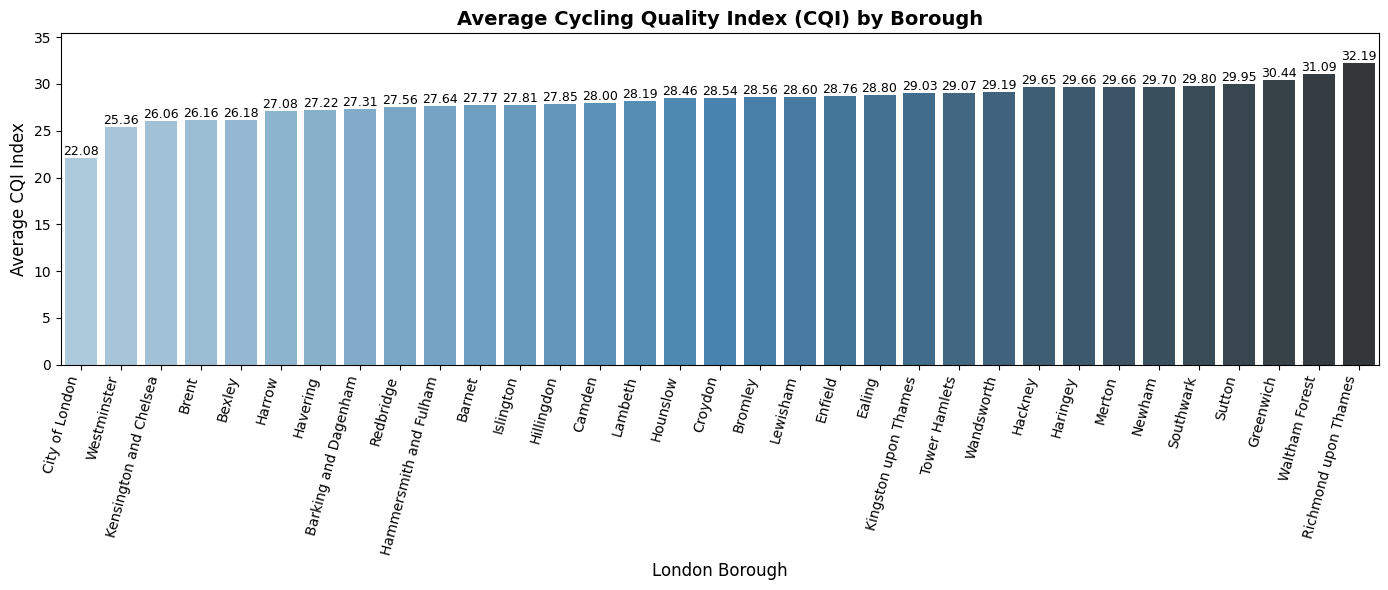

In [ ]:
# ========== 柱状图（均值） ==========
bar_df = borough_stats.sort_values(metric_col).reset_index(drop=True)

plt.figure(figsize=(14,6))
ax = sns.barplot(
    data=bar_df,
    x="borough_name",
    y=metric_col,
    palette="Blues_d"
)

# 设置 y 轴范围，给顶部留白 10%
ymax = bar_df[metric_col].max()
plt.ylim(0, ymax * 1.1)

# 数值标签放在柱子顶端
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                fontsize=9, color='black')

plt.xticks(rotation=75, ha="right")
plt.ylabel("Average CQI Index", fontsize=12)
plt.xlabel("London Borough", fontsize=12)
plt.title("Average Cycling Quality Index (CQI) by Borough", fontsize=14, weight="bold")
plt.tight_layout()
plt.savefig("AverageCQIbyBorough.png", dpi=300, bbox_inches="tight", pad_inches=0.15)
plt.show()

/tmp/ipython-input-1407051611.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_by_borough, labels=ordered_names, showfliers=True)


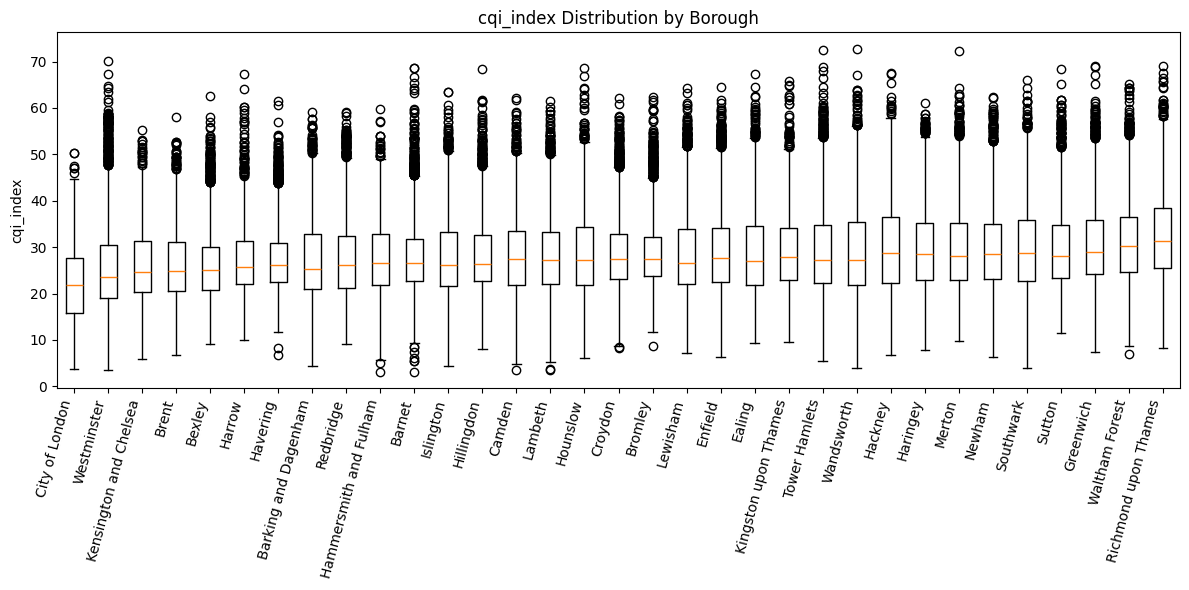

In [ ]:
# ========== ⑥ 箱线图（各 Borough 内部分布） ==========
# 设定分类顺序，保证 x 轴顺序与上图一致
cqi_use["borough_name"] = pd.Categorical(cqi_use["borough_name"],
                                         categories=ordered_names, ordered=True)

# 准备每个 borough 的数值列表
data_by_borough = [cqi_use.loc[cqi_use["borough_name"] == b, metric_col].values
                   for b in ordered_names]

plt.figure(figsize=(12, 6))
plt.boxplot(data_by_borough, labels=ordered_names, showfliers=True)
plt.xticks(rotation=75, ha="right")
plt.ylabel(metric_col)
plt.title(f"{metric_col} Distribution by Borough")
plt.tight_layout()

plt.savefig("box_cqi_by_borough.png", dpi=300, bbox_inches="tight", pad_inches=0.15)
plt.show()

In [ ]:
print(cqi.columns)

Index(['id', 'name', 'way_type', 'length_m', 'index_1_nor', 'index_1',
       'base_index', 'fac_1', 'fac_2', 'fac_3', 'fac_4', 'fac_5', 'LTS',
       'index_2_nor', 'index_2', 'fac_gvi', 'fac_no2', 'fac_nat',
       'index_3_nor', 'index_3', 'edge_betweenness', 'edge_closeness_2km',
       'edge_closeness_5km', '_B_log', 'B_norm', 'C2_norm', 'C5_norm',
       'C_multi', 'cqi_index', 'cqi_index_w1', 'cqi_index_w2', 'cqi_index_w3',
       'geometry'],
      dtype='object')


/tmp/ipython-input-309009777.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = (cqi_cut.groupby(["borough_name", "band"])


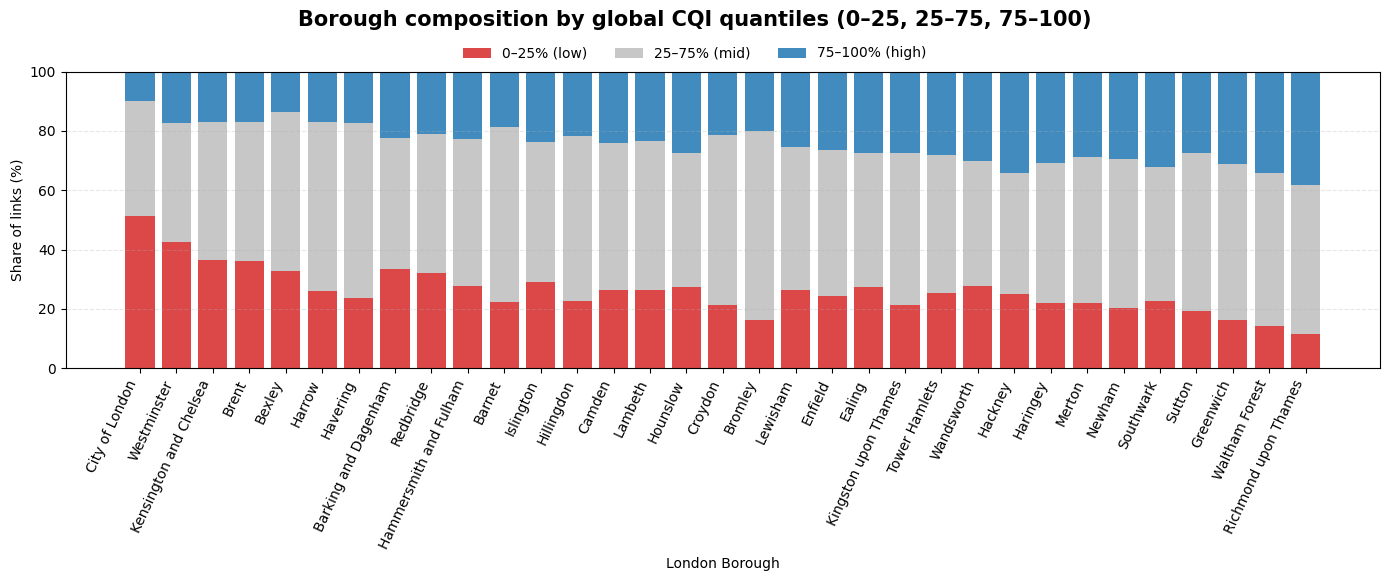

In [ ]:
# ========== 按全市总体分位的构成占比（竖向堆叠柱） ==========
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 使用与你前面一致的指标列
# metric_col 已在上文定义，如 "cqi_index"

# 1) 计算全市 25% 与 75% 分位
q25 = cqi_use[metric_col].quantile(0.25)
q75 = cqi_use[metric_col].quantile(0.75)

# 2) 划分三档：0–25%、25–75%、75–100%
bins   = [-np.inf, q25, q75, np.inf]
labels = ["0–25%", "25–75%", "75–100%"]

cqi_cut = cqi_use.copy()
cqi_cut["band"] = pd.cut(
    cqi_cut[metric_col], bins=bins, labels=labels,
    include_lowest=True, right=True
)

# 3) 按 borough 统计每档占比（%），并按 ordered_names 重排
counts = (cqi_cut.groupby(["borough_name", "band"])
          .size()
          .unstack("band")
          .reindex(index=ordered_names, columns=labels)
          .fillna(0))

shares = counts.div(counts.sum(axis=1), axis=0).mul(100)

# 4) 画竖向堆叠柱状图（红=低段，灰=中段，蓝=高段）
x = np.arange(len(ordered_names))
low  = shares["0–25%"].to_numpy()
mid  = shares["25–75%"].to_numpy()
high = shares["75–100%"].to_numpy()

fig, ax = plt.subplots(figsize=(14, 6))

# 三段堆叠柱
b1 = ax.bar(x, low,  label="0–25% (low)",  color="#d62728", alpha=0.85)
b2 = ax.bar(x, mid,  bottom=low,           label="25–75% (mid)", color="#c7c7c7")
b3 = ax.bar(x, high, bottom=low+mid,       label="75–100% (high)", color="#1f77b4", alpha=0.85)

# 轴与网格
ax.set_ylim(0, 100)
ax.set_ylabel("Share of links (%)")
ax.set_xlabel("London Borough")
ax.set_xticks(x)
ax.set_xticklabels(ordered_names, rotation=65, ha="right", fontsize=10)
ax.grid(axis="y", linestyle="--", alpha=0.3)

# ——把图例移到图外（标题下方），并为标题+图例预留空间——
handles = [b1, b2, b3]
labels  = ["0–25% (low)", "25–75% (mid)", "75–100% (high)"]
fig.legend(handles, labels, ncol=3, loc="upper center",
           bbox_to_anchor=(0.5, 0.92), frameon=False)

fig.suptitle("Borough composition by global CQI quantiles (0–25, 25–75, 75–100)",
             y=0.96, fontsize=15, fontweight="bold")

# 预留上边距，避免与标题/图例重叠
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("BoroughComposition.png", dpi=300, bbox_inches="tight", pad_inches=0.15)
plt.show()

## 看一下敏感性分析，这个模块应该放在前面的

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ===== 参数 =====
cols = ["cqi_index", "cqi_index_w1", "cqi_index_w2", "cqi_index_w3"]
for c in cols:
    assert c in cqi_use.columns, f"缺少列：{c}"

In [ ]:
# ===== 1) 计算 borough 均值（并按既定顺序重排）=====
borough_means = (cqi_use.groupby("borough_name")[cols]
                 .mean(numeric_only=True)
                 .reindex(ordered_names))

/tmp/ipython-input-2661878656.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  borough_means = (cqi_use.groupby("borough_name")[cols]


In [ ]:
# ===== 2) 稳健性量化：相关系数 =====
print("=== Pearson 相关（基于 borough 均值）===")
print(borough_means.corr(method="pearson").round(3))
print("\n=== Spearman 等级相关（基于 borough 均值）===")
print(borough_means.corr(method="spearman").round(3))

=== Pearson 相关（基于 borough 均值）===
              cqi_index  cqi_index_w1  cqi_index_w2  cqi_index_w3
cqi_index         1.000         0.971         0.889         0.708
cqi_index_w1      0.971         1.000         0.780         0.788
cqi_index_w2      0.889         0.780         1.000         0.316
cqi_index_w3      0.708         0.788         0.316         1.000

=== Spearman 等级相关（基于 borough 均值）===
              cqi_index  cqi_index_w1  cqi_index_w2  cqi_index_w3
cqi_index         1.000         0.956         0.742         0.760
cqi_index_w1      0.956         1.000         0.585         0.813
cqi_index_w2      0.742         0.585         1.000         0.213
cqi_index_w3      0.760         0.813         0.213         1.000


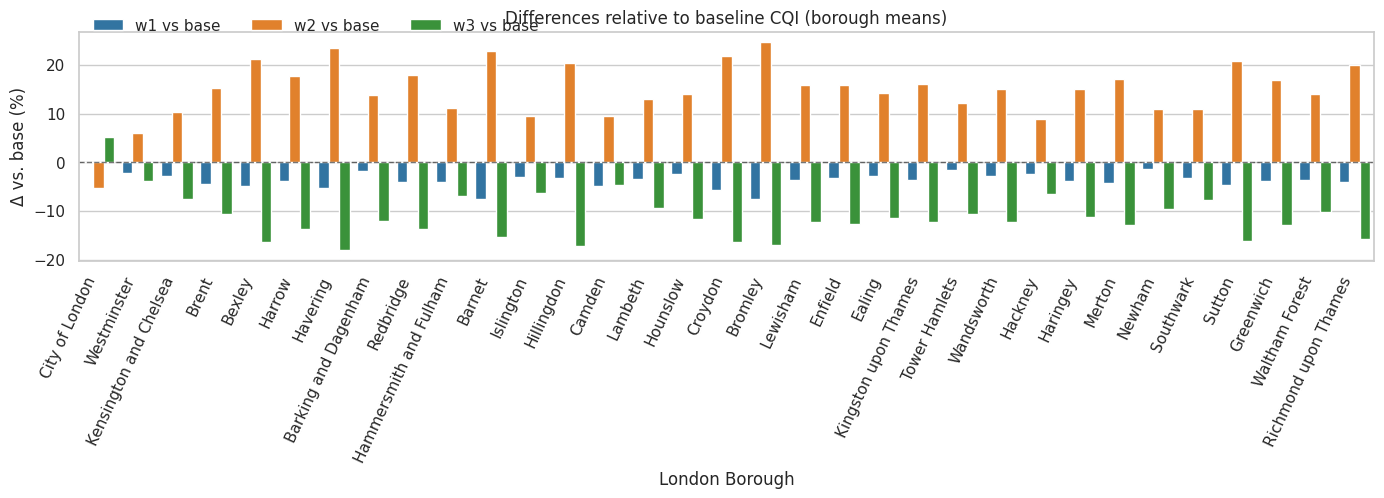

In [ ]:
# ===== 3) 图1：差异条形图（相对基线的百分比差异）=====
# Δ% = (wx - base) / base * 100
delta_pct = (borough_means[["cqi_index_w1","cqi_index_w2","cqi_index_w3"]]
             .subtract(borough_means["cqi_index"], axis=0)
             .div(borough_means["cqi_index"], axis=0)
             .mul(100))

plot_df = (delta_pct
           .reset_index()
           .melt(id_vars="borough_name",
                 var_name="variant", value_name="delta_pct"))

# 友好显示名称
name_map = {"cqi_index_w1":"w1 vs base",
            "cqi_index_w2":"w2 vs base",
            "cqi_index_w3":"w3 vs base"}
plot_df["variant"] = plot_df["variant"].map(name_map)

sns.set_theme(style="whitegrid", font_scale=1.0)
plt.figure(figsize=(14,6))
ax = sns.barplot(data=plot_df, x="borough_name", y="delta_pct",
                 hue="variant", palette=["#1f77b4","#ff7f0e","#2ca02c"])
ax.axhline(0, ls="--", lw=1, color="k", alpha=0.6)
ax.set_xlabel("London Borough")
ax.set_ylabel("Δ vs. base (%)")
ax.set_title("Differences relative to baseline CQI (borough means)")
plt.xticks(rotation=65, ha="right")
ax.legend(title="", ncol=3, loc="upper left", bbox_to_anchor=(0,1.12), frameon=False)
plt.tight_layout(rect=[0,0,1,0.9])

# 保存
out_dir = "/content/drive/MyDrive/CASA0004_Cycling/outputs"
os.makedirs(out_dir, exist_ok=True)
plt.savefig(os.path.join(out_dir, "cqi_robustness_delta_bar.png"),
            dpi=300, bbox_inches="tight", pad_inches=0.15)
plt.show()

/tmp/ipython-input-4071629684.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  borough_means = (cqi_use.groupby("borough_name")[cols]


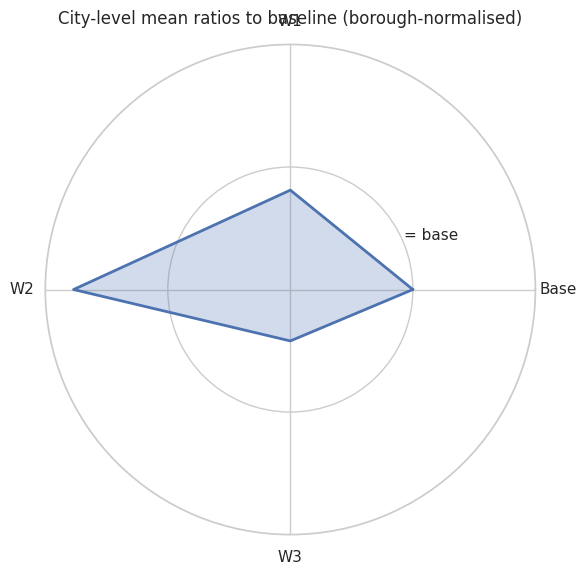

雷达比值（>1 表示高于基线，<1 低于基线）：
Base    1.000
W1      0.964
W2      1.149
W3      0.888
dtype: float64


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

out_dir = "/content/drive/MyDrive/CASA0004_Cycling/outputs"
os.makedirs(out_dir, exist_ok=True)

# ---- (1) 先得到 borough 均值表（若上面已有，可复用） ----
cols = ["cqi_index","cqi_index_w1","cqi_index_w2","cqi_index_w3"]
borough_means = (cqi_use.groupby("borough_name")[cols]
                 .mean(numeric_only=True)
                 .reindex(ordered_names))

# ---- (2) 先按 borough 归一到 base，再对 borough 求平均（更稳健）----
ratio_per_borough = borough_means.div(borough_means["cqi_index"], axis=0)
city_ratio = ratio_per_borough.mean(axis=0, skipna=True)  # Series: 每个指标相对 base 的城市平均比

# 组装为雷达需要的顺序；丢掉 NaN
radar = pd.Series({
    "Base": 1.0,
    "W1":  city_ratio.get("cqi_index_w1", np.nan),
    "W2":  city_ratio.get("cqi_index_w2", np.nan),
    "W3":  city_ratio.get("cqi_index_w3", np.nan),
}).dropna()

labels = radar.index.tolist()
values = radar.values

# 闭合
angles = np.linspace(0, 2*np.pi, len(values), endpoint=False)
angles = np.concatenate([angles, angles[:1]])
values = np.concatenate([values, values[:1]])

# ---- (3) 半径围绕 1 对称缩放，保证可读 ----
span = np.nanmax(np.abs(radar.values - 1.0))
if not np.isfinite(span) or span < 0.02:
    span = 0.1  # 最小跨度，避免太平
lo, hi = 1.0 - span*1.3, 1.0 + span*1.3

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, polar=True)
ax.plot(angles, values, linewidth=2)
ax.fill(angles, values, alpha=0.25)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_ylim(lo, hi)
ax.set_yticks([1.0])
ax.set_yticklabels(["= base"])

ax.set_title("City-level mean ratios to baseline (borough-normalised)", pad=15)
plt.tight_layout()
fig.savefig(os.path.join(out_dir, "cqi_robustness_radar_fixed.png"),
            dpi=300, bbox_inches="tight", pad_inches=0.15)
plt.show()

print("雷达比值（>1 表示高于基线，<1 低于基线）：")
print(radar.round(3))


In [ ]:
# ===== 5) 可选：稳健性摘要（文字）=====
max_abs_delta = delta_pct.abs().max().round(2)
print("\n各 Borough 最大绝对百分比差（相对 base）：")
print(max_abs_delta.rename(index=name_map))


各 Borough 最大绝对百分比差（相对 base）：
w1 vs base     7.54
w2 vs base    24.64
w3 vs base    18.06
dtype: float64


## 一点佐证代码（直接粘贴可跑）
A. 验证三个子指数的城市均值与分布（解释 w2 上移 / w3 下移的根因）

In [ ]:
# 城市层面均值（基于 cqi_use，已归一化到[0,100]）
sub_cols = ["index_1_nor","index_2_nor","index_3_nor"]
city_means = cqi_use[sub_cols].mean().sort_values(ascending=False)
print("City-wide mean of sub-indices:\n", city_means.round(2))

# 各子指数的分位（看是否 index_2 偏高、index_3 偏低）
print("\nQuantiles (0.25/0.5/0.75):")
print(cqi_use[sub_cols].quantile([0.25,0.5,0.75]).round(2))


City-wide mean of sub-indices:
 index_2_nor    46.22
index_1_nor    24.25
index_3_nor    15.02
dtype: float64

Quantiles (0.25/0.5/0.75):
      index_1_nor  index_2_nor  index_3_nor
0.25        14.29        36.61         0.82
0.50        22.45        45.48         5.37
0.75        29.59        55.75        24.71


B. “谁在推动 Δ？”——把 w2/w3 相对基线的变化分解为各子指数的贡献

这能直接证明：w2 的上移主要来自 index_2，w3 的下移主要来自 index_3。

/tmp/ipython-input-1908931737.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bm = (cqi_use.groupby("borough_name")[sub_cols]
/tmp/ipython-input-1908931737.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(bm.index, rotation=65, ha="right")


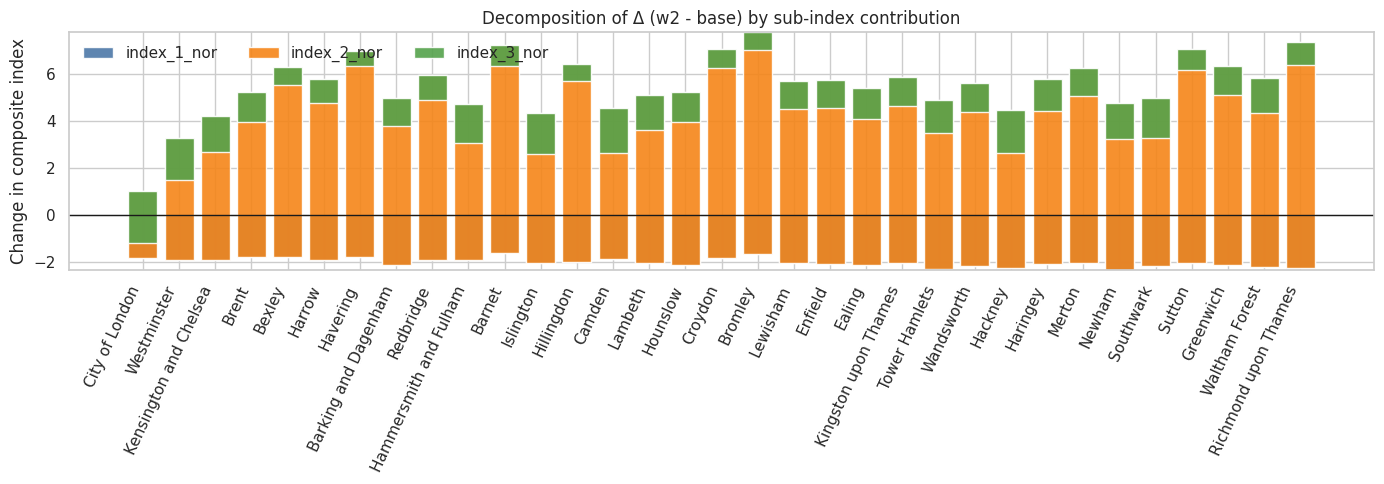

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 基线与变体权重
w_base = np.array([1/3, 1/3, 1/3])
w_w2   = np.array([0.25, 0.50, 0.25])  # 环境感知偏重
w_w3   = np.array([0.25, 0.25, 0.50])  # 中心性偏重

d_w2 = w_w2 - w_base
d_w3 = w_w3 - w_base

# 各区子指数均值
bm = (cqi_use.groupby("borough_name")[sub_cols]
      .mean(numeric_only=True).reindex(ordered_names))

# 贡献 = 权重变化 * 子指数均值
contrib_w2 = bm.mul(d_w2, axis=1)
contrib_w2["Δ_total"] = contrib_w2.sum(axis=1)

contrib_w3 = bm.mul(d_w3, axis=1)
contrib_w3["Δ_total"] = contrib_w3.sum(axis=1)

# 画一个示例：w2 的贡献堆叠（每个 borough 的 Δ 由三个子指数贡献堆起来）
fig, ax = plt.subplots(figsize=(14,5))
bottom = np.zeros(len(bm))
for col, color in zip(sub_cols, ["#4C78A8","#F58518","#54A24B"]):
    ax.bar(bm.index, contrib_w2[col], bottom=bottom, label=col, color=color, alpha=0.9)
    bottom += contrib_w2[col].to_numpy()
ax.axhline(0, color="k", lw=1)
ax.set_title("Decomposition of Δ (w2 - base) by sub-index contribution")
ax.set_ylabel("Change in composite index")
ax.set_xticklabels(bm.index, rotation=65, ha="right")
ax.legend(ncol=3, frameon=False)
plt.tight_layout()
plt.show()


C. 排序稳健性的一个附加指标（可入表）

In [ ]:
from scipy.stats import kendalltau

# Borough 排名（数值越大排名越靠前）
rank_base = borough_means["cqi_index"].rank(ascending=False, method="min")
for v in ["cqi_index_w1","cqi_index_w2","cqi_index_w3"]:
    tau, p = kendalltau(rank_base, borough_means[v].rank(ascending=False, method="min"))
    print(f"Kendall's tau(base vs {v}): {tau:.3f} (p={p:.3g})")


Kendall's tau(base vs cqi_index_w1): 0.841 (p=9e-17)
Kendall's tau(base vs cqi_index_w2): 0.572 (p=7.08e-07)
Kendall's tau(base vs cqi_index_w3): 0.564 (p=1.05e-06)


Sensitivity tests show that the equal-weight baseline is robust to mild re-weighting (w1; r=0.971, ρ=0.956; max |Δ|=7.5%). Emphasising Perceptual Environment (w2) produces systematic level increases (+10–25%), whereas emphasising Network Centrality (w3) leads to level decreases (−8–18%), with moderate rank shifts. This pattern is consistent with city-wide sub-index distributions: the environmental component attains higher means, while centrality underperforms on average. The low association between w2 and w3 indicates complementary spatial logics rather than redundancy. We therefore retain the equal-weight index for headline results and present w2/w3 as policy-relevant bounds for scenarios prioritising amenity versus connectivity.*

# 临时文件——做一下第二模块环境感知的1-3共线性

In [ ]:
index2 = gpd.read_file("/content/drive/MyDrive/CASA0004_Cycling/data/CQI/index_s2.gpkg")
print(index2.columns)

Index(['id', 'name', 'way_type', 'gvi_final', 'fac_gvi', 'NO2_mean', 'fac_no2',
       'natural_score', 'fac_nat', 'index_2', 'geometry'],
      dtype='object')


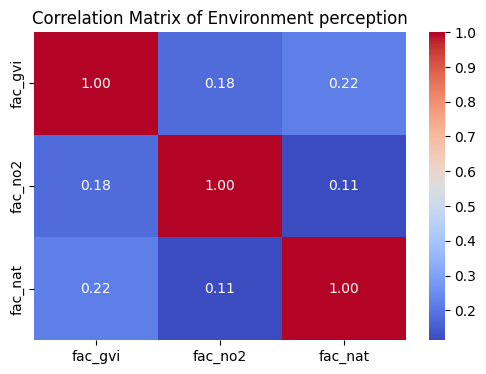

  Variable        VIF
0    const  17.809793
1  fac_gvi   1.077132
2  fac_no2   1.038742
3  fac_nat   1.057190


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# 选取要检验的列
cols = ['fac_gvi', 'fac_no2', 'fac_nat']
df = index2[cols].dropna().astype(float)  # 转换成数值型并去掉NA

# ==== 相关性矩阵 ====
corr = df.corr(method='pearson')  # 也可以改成 'spearman' 或 'kendall'
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Environment perception")
plt.savefig("CorrelationMatrixS2.png", dpi=300, bbox_inches="tight", pad_inches=0.15)
plt.show()

# ==== VIF 检验 ====
X = add_constant(df)  # 添加截距项
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

In [ ]:
index1 = gpd.read_file("/content/drive/MyDrive/CASA0004_Cycling/data/CQI/index_s1.gpkg")
print(index1.columns)

Index(['id', 'name', 'way_type', 'index', 'index_10', 'stress_level', 'offset',
       'side', 'proc_width', 'proc_surface', 'proc_smoothness', 'proc_oneway',
       'proc_sidepath', 'proc_highway', 'proc_maxspeed',
       'proc_traffic_mode_left', 'proc_traffic_mode_right',
       'proc_separation_left', 'proc_separation_right', 'proc_buffer_left',
       'proc_buffer_right', 'proc_mandatory', 'proc_traffic_sign', 'fac_width',
       'fac_surface', 'fac_highway', 'fac_maxspeed', 'base_index', 'fac_1',
       'fac_2', 'fac_3', 'fac_4', 'data_bonus', 'data_malus',
       'data_incompleteness', 'data_missing', 'data_missing_width',
       'data_missing_surface', 'data_missing_smoothness',
       'data_missing_maxspeed', 'data_missing_parking', 'data_missing_lit',
       'filter_usable', 'filter_way_type', 'proc_slope', 'fac_5', 'layer',
       'path', 'geometry'],
      dtype='object')


In [ ]:
print(index1["way_type"].value_counts())

way_type
shared road            80784
shared traffic lane    27278
track or service       21978
shared path            18813
cycle track             5946
shared footway          4271
crossing                3969
cycle path               940
link                      68
segregated path           28
bicycle road               1
Name: count, dtype: int64


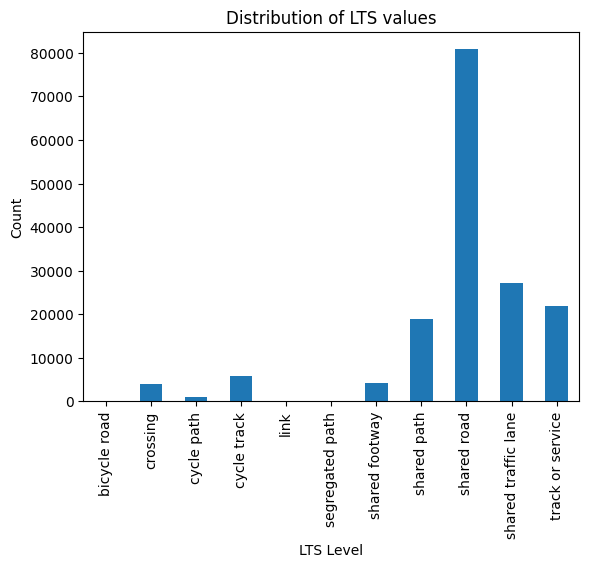

In [ ]:
index1["way_type"].value_counts().sort_index().plot(kind="bar")
plt.xlabel("LTS Level")
plt.ylabel("Count")
plt.title("Distribution of LTS values")
plt.show()

## 写一点硬件上的fac

In [ ]:
index1 = gpd.read_file("/content/drive/MyDrive/CASA0004_Cycling/data/CQI/index_s1.gpkg")
print(index1.columns)

Index(['id', 'name', 'way_type', 'index', 'index_10', 'stress_level', 'offset',
       'side', 'proc_width', 'proc_surface', 'proc_smoothness', 'proc_oneway',
       'proc_sidepath', 'proc_highway', 'proc_maxspeed',
       'proc_traffic_mode_left', 'proc_traffic_mode_right',
       'proc_separation_left', 'proc_separation_right', 'proc_buffer_left',
       'proc_buffer_right', 'proc_mandatory', 'proc_traffic_sign', 'fac_width',
       'fac_surface', 'fac_highway', 'fac_maxspeed', 'base_index', 'fac_1',
       'fac_2', 'fac_3', 'fac_4', 'data_bonus', 'data_malus',
       'data_incompleteness', 'data_missing', 'data_missing_width',
       'data_missing_surface', 'data_missing_smoothness',
       'data_missing_maxspeed', 'data_missing_parking', 'data_missing_lit',
       'filter_usable', 'filter_way_type', 'proc_slope', 'fac_5', 'layer',
       'path', 'geometry'],
      dtype='object')


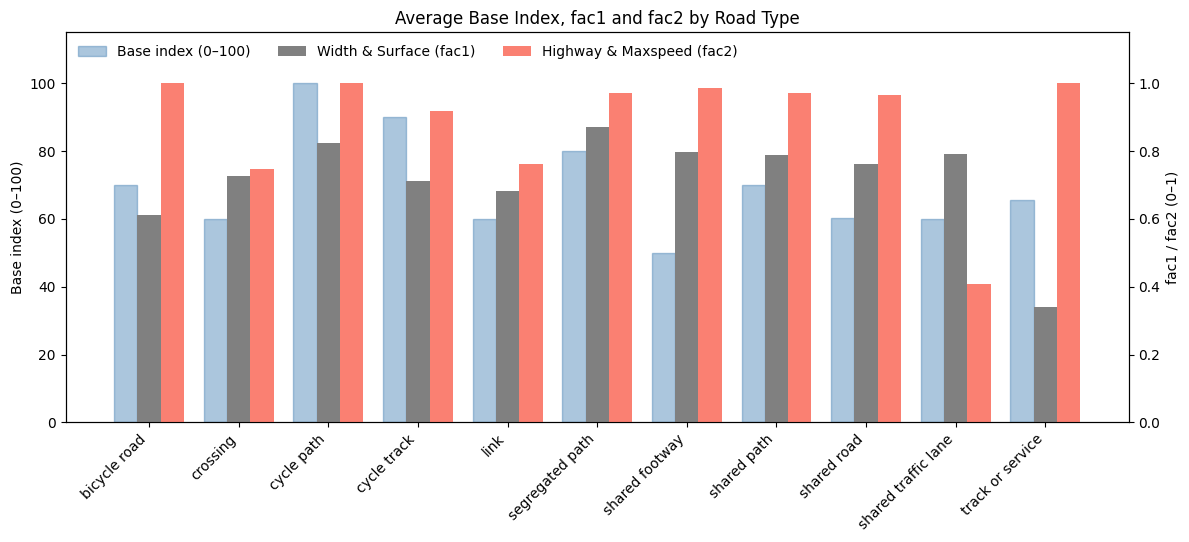

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd

# 提取所需字段
df = index1[['way_type', 'base_index', 'fac_1', 'fac_2']].copy()

# 按道路类型聚合
df_grouped = df.groupby('way_type').mean().reset_index()

# 类别与位置
cats = df_grouped['way_type'].tolist()
x = np.arange(len(cats))
width = 0.26

fig, ax = plt.subplots(figsize=(12, 6))
ax2 = ax.twinx()  # 右侧 y 轴给 base_index

# 三个并列柱（-w, 0, +w）
b0 = ax.bar(x - width, df_grouped['base_index'], width=width,
            label='Base index (0–100)', color='steelblue', alpha=0.45, edgecolor='steelblue')
b1 = ax2.bar(x, df_grouped['fac_1'], width=width,
             label='Width & Surface (fac1)', color='gray')
b2 = ax2.bar(x + width, df_grouped['fac_2'], width=width,
             label='Highway & Maxspeed (fac2)', color='salmon')

# 坐标轴与标签（注意左右轴对应）
ax.set_ylim(0, 115)         # 左：base_index
ax2.set_ylim(0, 1.15)       # 右：fac1/fac2

ax.set_xticks(x)
ax.set_xticklabels(cats, rotation=45, ha='right')
ax.set_ylabel('Base index (0–100)')      # ← 修正
ax2.set_ylabel('fac1 / fac2 (0–1)')      # ← 修正
ax.set_title('Average Base Index, fac1 and fac2 by Road Type')

# 合并图例并放到图上方
handles, labels = [], []
for a in (ax, ax2):
    h, l = a.get_legend_handles_labels()
    handles += h; labels += l

leg = ax.legend(handles, labels,
                loc='lower left', bbox_to_anchor=(0, 0.9),  # 轴上方
                ncol=3, frameon=False)
leg.set_zorder(10)  # 确保盖在柱子之上

# 给上方留点空间以免被裁剪
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.savefig("S1_roadtype.png", dpi=300, bbox_inches="tight", pad_inches=0.15)
plt.show()

### s1总函数饼图

In [16]:
s1count = gpd.read_file("/content/drive/MyDrive/CASA0004_Cycling/data/CQI/CQI_nor.gpkg")
print(s1count.columns)

Index(['id', 'name', 'way_type', 'length_m', 'index_1_nor', 'index_1',
       'base_index', 'fac_1', 'fac_2', 'fac_3', 'fac_4', 'fac_5', 'LTS',
       'index_2_nor', 'index_2', 'fac_gvi', 'fac_no2', 'fac_nat',
       'index_3_nor', 'index_3', 'edge_betweenness', 'edge_closeness_2km',
       'edge_closeness_5km', '_B_log', 'B_norm', 'C2_norm', 'C5_norm',
       'C_multi', 'cqi_index', 'cqi_index_w1', 'cqi_index_w2', 'cqi_index_w3',
       'geometry'],
      dtype='object')


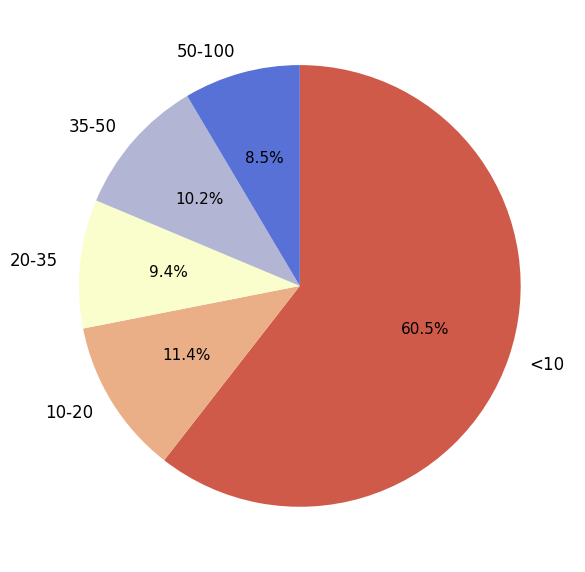

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# 分级区间
bins = [0, 10, 20, 35, 50, 100]
labels = ["<10", "10-20", "20-35", "35-50", "50-100"]

# 按区间分组
s1count["index_3_nor_bin"] = pd.cut(s1count["index_3_nor"], bins=bins, labels=labels, right=False)

# 统计每个区间数量
counts = s1count["index_3_nor_bin"].value_counts().sort_index()

# 你的图例配色（保持一致）
colors = [
    "#D05A49",  # 0-15 红褐
    "#EBAF88",  # 15-25 橙
    "#F9FECC",  # 25-35 浅黄
    "#B2B5D4",  # 35-45 浅紫灰（如果你的图里是灰偏紫，可以调）
    "#5771D6"   # 45-100 深蓝
]

# 画饼图
fig, ax = plt.subplots(figsize=(6,6))
wedges, texts, autotexts = ax.pie(
    counts,
    labels=counts.index,
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    colors=colors,
    textprops={'fontsize': 12}
)

# 美化百分比
for t in autotexts:
    t.set_color("black")
    t.set_fontsize(11)

# 去掉标题（方便贴到地图右下角）
plt.tight_layout()
plt.savefig("0.png", dpi=300, bbox_inches="tight", pad_inches=0.15)
plt.show()

In [ ]:
print(s1count["fac_4"].value_counts())

fac_4
1.00    155507
0.90      3045
1.10      2360
0.80       991
1.20       689
0.70       323
1.25         7
1.05         2
1.35         2
1.15         1
Name: count, dtype: int64


In [ ]:
import statsmodels.api as sm

X = s1count[["fac_4"]]
y = s1count["index_1_nor"]

# 加常数项
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

# R² 就是 fac_4 对 index_1 的贡献率
print("R² (explained variance):", model.rsquared)


# 做个s3

In [10]:
import matplotlib.pyplot as plt
import pandas as pd


In [4]:
s3 = gpd.read_file("/content/drive/MyDrive/CASA0004_Cycling/data/CQI/index_s3.gpkg")

In [7]:
print(s3.columns)

Index(['id', 'name', 'way_type', 'length_m', 'edge_betweenness',
       'edge_closeness_hc', 'edge_closeness_2km', 'edge_closeness_5km',
       '_B_log', 'B_norm', 'C2_norm', 'C5_norm', 'C_multi', 'index_3',
       'geometry'],
      dtype='object')


In [8]:
print(s3["C_multi"].value_counts())

C_multi
0.000000    249
0.010541      9
0.010060      6
0.009583      6
0.009944      6
           ... 
0.007526      1
0.000582      1
0.000580      1
0.004234      1
0.028592      1
Name: count, Length: 162167, dtype: int64


In [14]:
print(s3["C_multi"].max())

1.0


In [12]:
s3["C_multi"].value_counts().sort_index().plot(kind="bar")
plt.xlabel("LTS Level")
plt.ylabel("Count")
plt.title("Distribution of LTS values")
plt.show()

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7ca9d567e020> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7ca9d5667b00> (for post_execute):


KeyboardInterrupt: 